In [1]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for data preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils import resample

# Import packages for data modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
### Five Business Quesiton:

#1. What drives our ride demand throughout the day, week, and month?
#2. What factors influence trip duration?
#3. What pickup zones/borough generate the highest revenue and its average?
#4. At what times of day are trips most profitable?
#5. How does passenger tipping behavior vary by time, distance, and borough?


In [3]:
df = pd.read_csv('2017_Yellow_Taxi_Trip_Data.csv')

In [4]:
df.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80


In [5]:
# Double check to confirm the data is clean for analysis
df.isna().sum()

Unnamed: 0               0
VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
dtype: int64

In [6]:
### Question - 1. What drives our ride demand throughout the day, week, and month?

In [7]:
# Convert to datetime for better use
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

In [8]:
# Create seperate column from the original pickup and dropoff column.
df['pickup_date'] = df['tpep_pickup_datetime'].dt.date
df['pickup_time'] = df['tpep_pickup_datetime'].dt.time

df['dropoff_date'] = df['tpep_dropoff_datetime'].dt.date
df['dropoff_time'] = df['tpep_dropoff_datetime'].dt.time

In [9]:
# Extract hours, DOW, and month for furthur analysis
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['pickup_dow'] = df['tpep_pickup_datetime'].dt.dayofweek
df['pickup_month'] = df['tpep_pickup_datetime'].dt.month

In [10]:
# I think this would be useful factor to answer the first question
def categorize_time(hour):
    if 5 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 17:
        return "Afternoon"
    elif 17 <= hour < 22:
        return "Evening"
    else:
        return "Night"

df['time_of_day'] = df['pickup_hour'].apply(categorize_time)

In [11]:
df.head(2)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,improvement_surcharge,total_amount,pickup_date,pickup_time,dropoff_date,dropoff_time,pickup_hour,pickup_dow,pickup_month,time_of_day
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,...,0.3,16.56,2017-03-25,08:55:43,2017-03-25,09:09:47,8,5,3,Morning
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,...,0.3,20.80,2017-04-11,14:53:28,2017-04-11,15:19:58,14,1,4,Afternoon


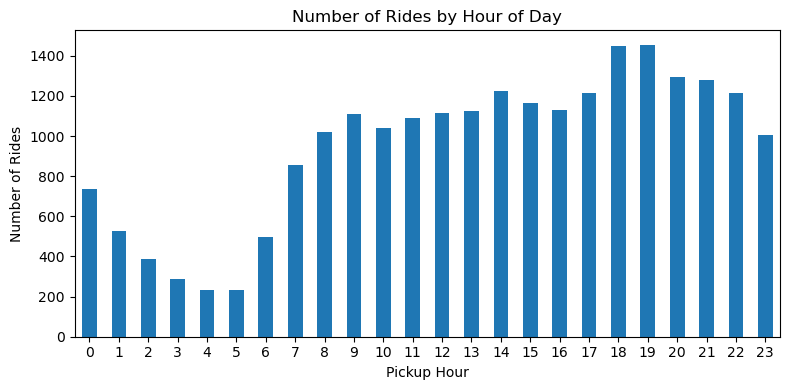

In [12]:
### Day ###

# Group by hour and count rides
rides_by_hour = df.groupby('pickup_hour').size()

plt.figure(figsize=(8, 4))
rides_by_hour.plot(kind='bar')
plt.title('Number of Rides by Hour of Day')
plt.xlabel('Pickup Hour')
plt.ylabel('Number of Rides')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

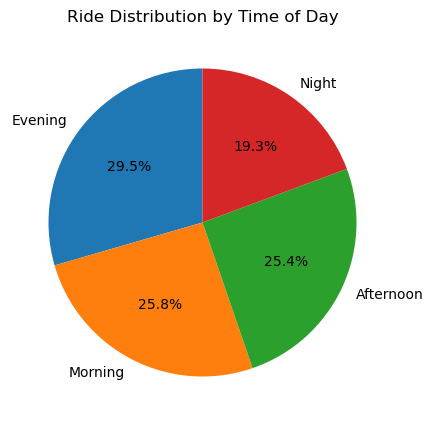

In [13]:
# Furthur exploration

rides_by_tod = df['time_of_day'].value_counts()

plt.figure(figsize=(5,5))
plt.pie(
    rides_by_tod,
    labels=rides_by_tod.index,
    autopct='%1.1f%%',
    startangle=90)
plt.title('Ride Distribution by Time of Day')
plt.show()

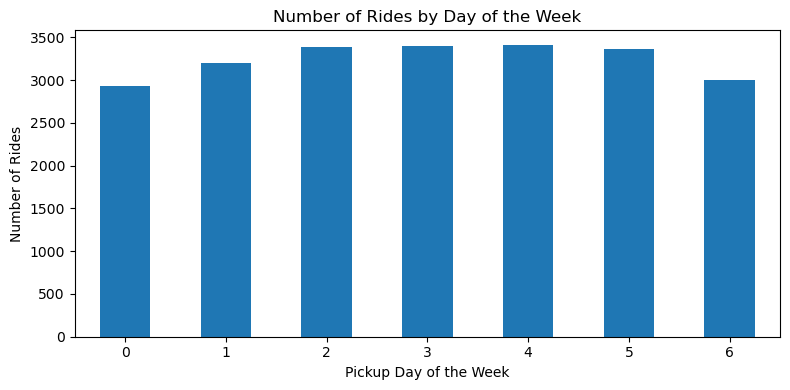

In [14]:
### Week ###

# DOW analysis
rides_by_dow = df.groupby('pickup_dow').size()

plt.figure(figsize=(8, 4))
rides_by_dow.plot(kind='bar')
plt.title('Number of Rides by Day of the Week')
plt.xlabel('Pickup Day of the Week')
plt.ylabel('Number of Rides')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 0 = Monday, 6 = Sunday

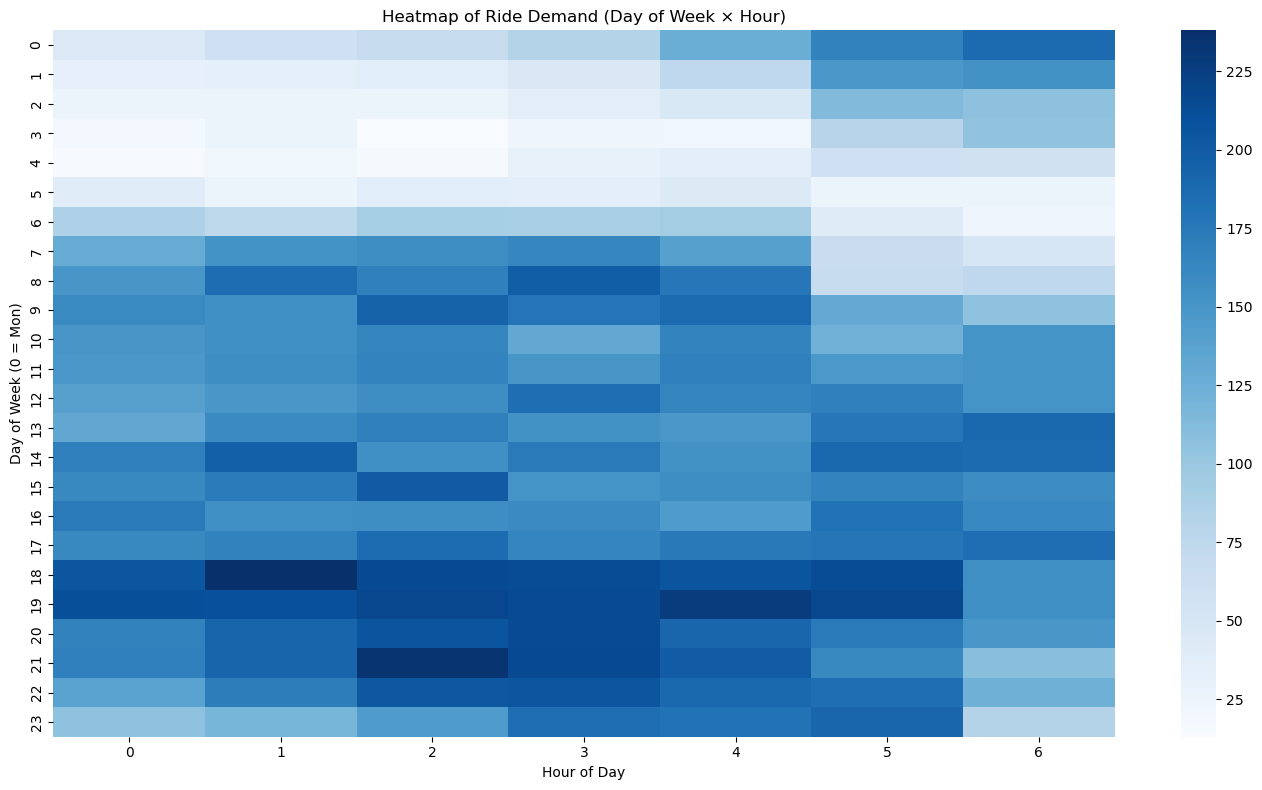

In [15]:
# Since the bar chart distribution were distributed evenly, it is very difficult to gain any insights.

# Pivot table for heatmap
heatmap_data = df.pivot_table(
    index='pickup_hour', 
    columns='pickup_dow', 
    values='tpep_pickup_datetime', 
    aggfunc='count'
)

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, cmap='Blues')
plt.title('Heatmap of Ride Demand (Day of Week × Hour)')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week (0 = Mon)')
plt.tight_layout()
plt.show()

# 0 = Monday, 6 = Sunday

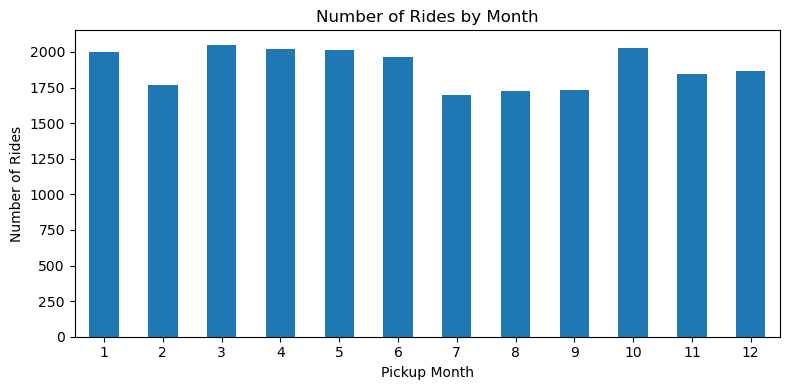

In [16]:
### Month ##

rides_by_month = df.groupby('pickup_month').size()

plt.figure(figsize=(8, 4))
rides_by_month.plot(kind='bar')
plt.title('Number of Rides by Month')
plt.xlabel('Pickup Month')
plt.ylabel('Number of Rides')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



In [17]:
# 1. What drives our ride demand throughout the day, week, and month?
print('Question 1 - Insights: ')
print('1) From the bar chart as well as pie chart above, the "peak" hours in a day usually occured in the evening (5pm up to 9:59pm)')
print('2) Based on the heatmap, rides demand slowly increase in the afternoon (right after 12pm) during the week. In terms of weekend, especially Fridays and Saturdays evening we could see a potential increase in ride demand. Might be because people are going out at night during their weekend')
print('3) Third quarter (July to September) rides demands lower compared to the rest. This can be because tourism season is over.')






Question 1 - Insights: 
1) From the bar chart as well as pie chart above, the "peak" hours in a day usually occured in the evening (5pm up to 9:59pm)
2) Based on the heatmap, rides demand slowly increase in the afternoon (right after 12pm) during the week. In terms of weekend, especially Fridays and Saturdays evening we could see a potential increase in ride demand. Might be because people are going out at night during their weekend
3) Third quarter (July to September) rides demands lower compared to the rest. This can be because tourism season is over.


In [18]:
### Question - 2. What factors influence trip duration?


In [19]:
df['trip_duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
df['trip_duration_minutes'] = df['trip_duration'].dt.total_seconds() / 60

df.head(1)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,pickup_date,pickup_time,dropoff_date,dropoff_time,pickup_hour,pickup_dow,pickup_month,time_of_day,trip_duration,trip_duration_minutes
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,...,2017-03-25,08:55:43,2017-03-25,09:09:47,8,5,3,Morning,0 days 00:14:04,14.066667


In [20]:
# Initial Inspect

print('The average trip duration: ',df['trip_duration_minutes'].mean())
print('The median trip duration: ',df['trip_duration_minutes'].median())
print('')
print('Thought: There is a huge gap between median trip duration vs average trip duration. I inspect there are some outliers are in the dataset.')


The average trip duration:  17.013776671512694
The median trip duration:  11.183333333333334

Thought: There is a huge gap between median trip duration vs average trip duration. I inspect there are some outliers are in the dataset.


In [21]:
# Determine outliers if it could affect my analysis
print(df['trip_duration_minutes'].max())
print('Count of trip duration more than 60 minutes:', df[df['trip_duration_minutes'] >= 60]['trip_duration_minutes'].count())
print('Count of trip duration less than 60 minutes:',df[df['trip_duration_minutes']<60]['trip_duration_minutes'].count())
print('')
print('Thought: Since the majority of trip duration is less than an hour, I will use upper quartile to eliminate outliers.')

1439.55
Count of trip duration more than 60 minutes: 230
Count of trip duration less than 60 minutes: 22469

Thought: Since the majority of trip duration is less than an hour, I will use upper quartile to eliminate outliers.


In [22]:
# Eliminate trip-duration outliers (> 60 minutes) ----

# Define threshold in minutes
upper_threshold = 60   
lower_threshold = 0    

outlier_mask = (df['trip_duration_minutes'] > upper_threshold) | \
               (df['trip_duration_minutes'] <= lower_threshold)

# Count outliers 
outlier_count = outlier_mask.sum()
total_count = df['trip_duration_minutes'].count()
percent_outliers = (outlier_count / total_count) * 100

print(f'Number of outliers in trip_duration_minutes: '
      f'{outlier_count} out of {total_count} ({percent_outliers:.2f}%)')

# Remove outliers
df = df[~outlier_mask].copy()

Number of outliers in trip_duration_minutes: 257 out of 22699 (1.13%)


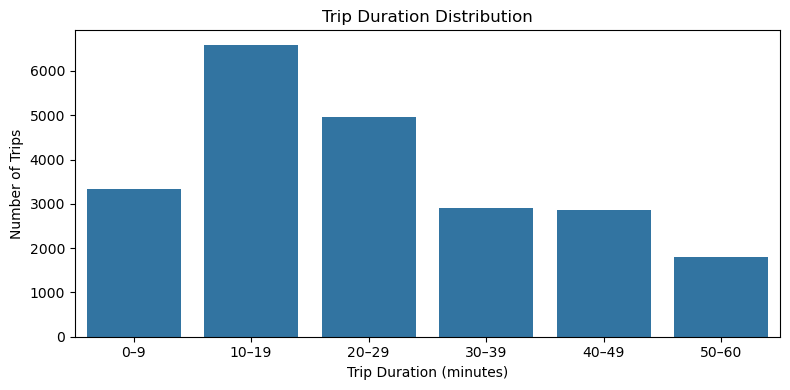

Insight: As a result, most taxi trip are ranging from 10-29 minutes.


In [23]:
# After remove outliers, the maximum trip duration will be 60 minutes, I'm now create 6 different bins to see which time duration is dominating


bins = [0, 5, 10, 15, 20, 30, 60]
labels = ['0–9', '10–19', '20–29', '30–39', '40–49', '50–60']

df['duration_bin'] = pd.cut(df['trip_duration_minutes'], bins=bins, labels=labels, right=False)


plt.figure(figsize=(8,4))
sns.countplot(
    data=df,
    x='duration_bin',
    order=labels
)

plt.title('Trip Duration Distribution')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Number of Trips')
plt.tight_layout()
plt.show()

print('Insight: As a result, most taxi trip are ranging from 10-29 minutes.')

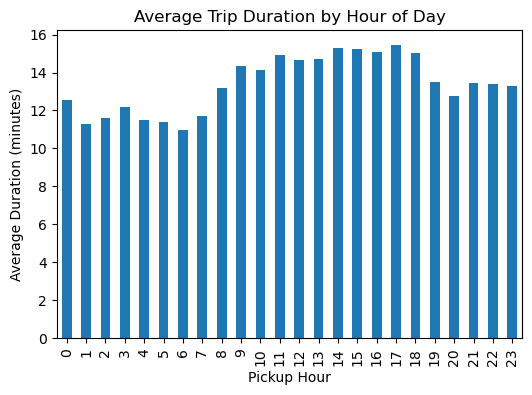

Average Trip Duration by Time Period: time_of_day
Afternoon    15.006235
Evening      14.040568
Morning      13.420560
Night        12.638011
Name: trip_duration_minutes, dtype: float64

Insight: Comparing average trip duration per time period, I can confident say that traffic does not have enough impact.


In [24]:
# My thouht after seeing the bar chart above, will traffic have any impact on trip duration?

duration_by_hour = df.groupby('pickup_hour')['trip_duration_minutes'].mean()

plt.figure(figsize=(6,4))
duration_by_hour.plot(kind='bar')
plt.title('Average Trip Duration by Hour of Day')
plt.xlabel('Pickup Hour')
plt.ylabel('Average Duration (minutes)')
plt.show()


avg_duration_by_period = df.groupby('time_of_day')['trip_duration_minutes'].mean()
print('Average Trip Duration by Time Period:', avg_duration_by_period)

print('')
print('Insight: Comparing average trip duration per time period, I can confident say that traffic does not have enough impact.')

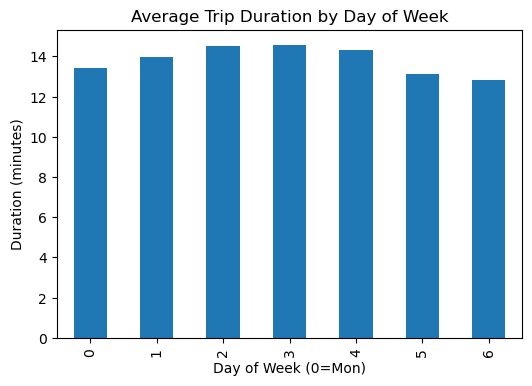

In [25]:
# Trip duration by day of week
duration_by_dow = df.groupby('pickup_dow')['trip_duration_minutes'].mean()

plt.figure(figsize=(6,4))
duration_by_dow.plot(kind='bar')
plt.title('Average Trip Duration by Day of Week')
plt.xlabel('Day of Week (0=Mon)')
plt.ylabel('Duration (minutes)')
plt.show()


In [53]:
# Since day of week and pick-up hour does not show a clear trend of having impact on trip duration
# My next thought would be pick-up location. Below is a brand new dataset I found on NYC website about PULocationID

zone_lookup = pd.read_csv('taxi_zone_lookup.csv')
df = df.merge(zone_lookup[['LocationID','Zone','Borough']], 
              left_on='PULocationID', right_on='LocationID', how='left')

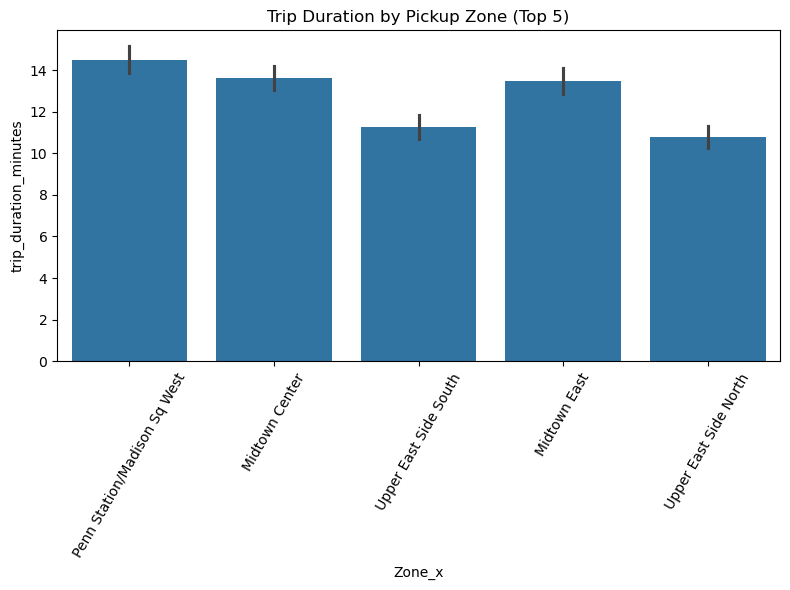

In [55]:
# Top 5 pickup zone and its trip duration in average

top_zones = df['Zone_x'].value_counts().head(5).index
zone_data = df[df['Zone_x'].isin(top_zones)]

plt.figure(figsize=(8,6))
sns.barplot(data=zone_data, x='Zone_x', y='trip_duration_minutes')
plt.title('Trip Duration by Pickup Zone (Top 5)')
plt.xticks(rotation = 60)
plt.tight_layout()
plt.show()

In [57]:
# Before remove outliers, the correlation between trip distance and trip duration was 0.156. 
# After removed outliers, the correlation is now higher

df[['trip_distance', 'trip_duration_minutes']].corr()

,trip_distance,trip_duration_minutes
trip_distance,1.000000,0.769148
trip_duration_minutes,0.769148,1.000000


<Axes: xlabel='trip_distance', ylabel='trip_duration_minutes'>

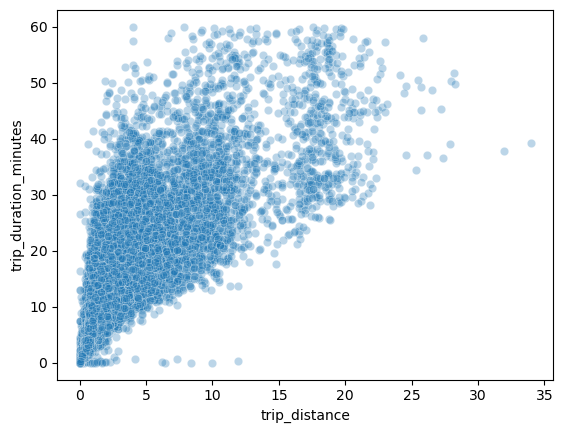

In [59]:
sns.scatterplot(x='trip_distance', y='trip_duration_minutes', data=df, alpha=0.3)

In [61]:
#2. What factors influence trip duration?
print('Question 2 - Insights: ')
print('1) There is a strong positive correlation between trip distance and trip duration. Longer distances consistently result in longer trip times.')
print('2) Evening hour showed a notch higher in trip duration. And most of taxi trip are ranging from 10 - 29 minutes.')
print('3) Pen Station/Madison Square + Midtown Center + Midtown East are areas with high density level. Theses zone experience higher traffic which result in longer trip duration.')


Question 2 - Insights: 
1) There is a strong positive correlation between trip distance and trip duration. Longer distances consistently result in longer trip times.
2) Evening hour showed a notch higher in trip duration. And most of taxi trip are ranging from 10 - 29 minutes.
3) Pen Station/Madison Square + Midtown Center + Midtown East are areas with high density level. Theses zone experience higher traffic which result in longer trip duration.


In [63]:
### Question - 3. What pickup zones/borough generate the highest revenue and its average?


In [65]:
# Highest Revenue by Borough
revenue_by_borough = df.groupby('Borough_x')['total_amount'].sum().sort_values(ascending = False)
avg_revenue_by_borough = df.groupby('Borough_x')['total_amount'].mean().sort_values(ascending = False)

print('Total Revenue by Borough:', revenue_by_borough)
print('')
print('Average Revenue by Borough:',avg_revenue_by_borough)

Total Revenue by Borough: Borough_x
Manhattan        288870.38
Queens            54836.87
Unknown            5552.90
Brooklyn           5291.10
EWR                 284.55
Bronx               273.23
Staten Island         7.30
Name: total_amount, dtype: float64

Average Revenue by Borough: Borough_x
EWR              94.850000
Queens           42.542180
Brooklyn         16.743987
Unknown          16.625449
Bronx            15.179444
Manhattan        14.113958
Staten Island     7.300000
Name: total_amount, dtype: float64


/var/folders/0y/4rkjz_214b7cqmfb9xs9h07c0000gn/T/ipykernel_45669/2145645925.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=revenue_by_borough.index, y=revenue_by_borough.values, palette="Blues_r")
/var/folders/0y/4rkjz_214b7cqmfb9xs9h07c0000gn/T/ipykernel_45669/2145645925.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_revenue_by_borough.index, y=avg_revenue_by_borough.values, palette="Greens_r")


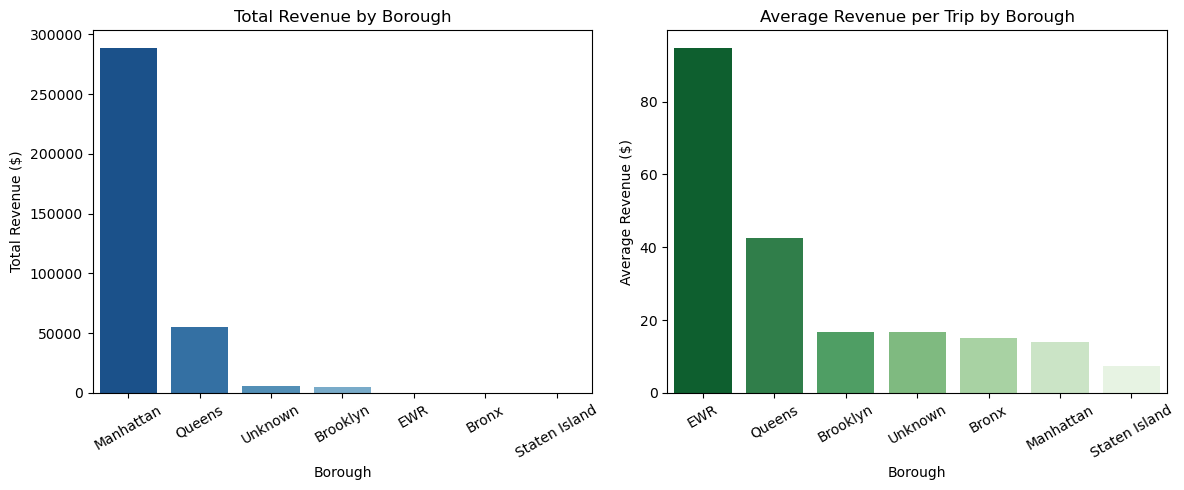

In [67]:
# Plot
plt.figure(figsize=(12, 5))

# Total Rev
plt.subplot(1, 2, 1)
sns.barplot(x=revenue_by_borough.index, y=revenue_by_borough.values, palette="Blues_r")
plt.title('Total Revenue by Borough')
plt.xlabel('Borough')
plt.ylabel('Total Revenue ($)')
plt.xticks(rotation=30)

# Average Rev
plt.subplot(1, 2, 2)
sns.barplot(x=avg_revenue_by_borough.index, y=avg_revenue_by_borough.values, palette="Greens_r")
plt.title('Average Revenue per Trip by Borough')
plt.xlabel('Borough')
plt.ylabel('Average Revenue ($)')
plt.xticks(rotation=30)

plt.tight_layout()
plt.show()


In [69]:
# Strongest Demand by Borough
demand_by_borough = df.groupby('Borough_x').size().sort_values(ascending = False)
print(demand_by_borough)


Borough_x
Manhattan        20467
Queens            1289
Unknown            334
Brooklyn           316
Bronx               18
EWR                  3
Staten Island        1
dtype: int64


In [71]:
#3. What pickup zones/borough generate the highest revenue and its average?
print('Question 3 - Insights: ')
print('1) Without a doubt, Manhattan generate the most revenue. On the other hand, EWR (airport) was the highest return on average per ride.')
print('2) I am immediately inspected this error. Turn out, the reason why EWR has the highest average revenue per trip is because of its limited ride requested (3 for EWR vs 20,000+ for Manhattan.')


Question 3 - Insights: 
1) Without a doubt, Manhattan generate the most revenue. On the other hand, EWR (airport) was the highest return on average per ride.
2) I am immediately inspected this error. Turn out, the reason why EWR has the highest average revenue per trip is because of its limited ride requested (3 for EWR vs 20,000+ for Manhattan.


In [79]:
### Question - 4. At what times of day are trips most profitable?


In [89]:
# To answer the stakeholder's question of what times of day are most profitable by revenue. I'll create a column within the dataset then plot it.

df['rev_per_min'] = df['total_amount'] / df['trip_duration_minutes']
profit_by_hour = df.groupby('pickup_hour')[['rev_per_min']].mean()                           



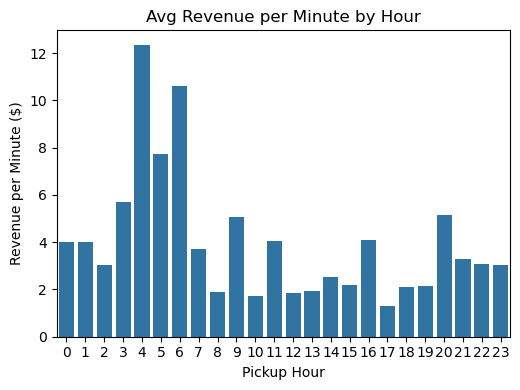

In [91]:
plt.figure(figsize=(10,4))

# Revenue per minute
plt.subplot(1, 2, 1)
sns.barplot(x=profit_by_hour.index, y=profit_by_hour['rev_per_min'])
plt.title('Avg Revenue per Minute by Hour')
plt.xlabel('Pickup Hour')
plt.ylabel('Revenue per Minute ($)')

plt.tight_layout()
plt.show()

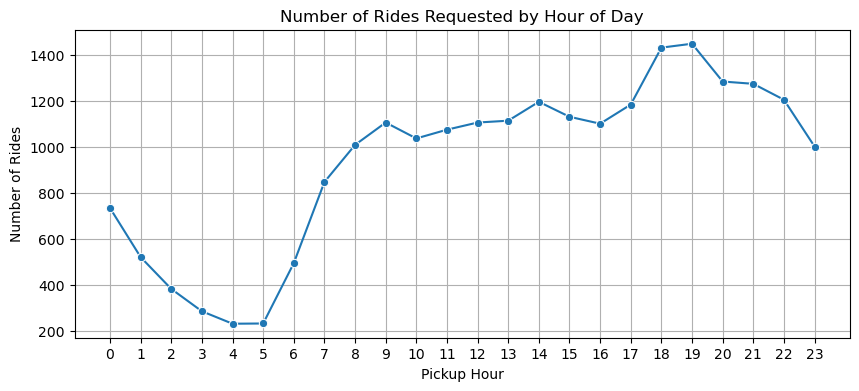

In [93]:
# Why don't driver just drive at night where its average revenue per minutes is the highest? That question led me to deeper analysis.
# I will create a visualization to display requested ride by hour of day to see the comparison.

rides_by_hour = df['pickup_hour'].value_counts().sort_index()

plt.figure(figsize=(10,4))
sns.lineplot(x=rides_by_hour.index, y=rides_by_hour.values, marker='o')

plt.title('Number of Rides Requested by Hour of Day')
plt.xlabel('Pickup Hour')
plt.ylabel('Number of Rides')
plt.xticks(range(0, 24))
plt.grid(True)

plt.show()

In [95]:
#4. At what times of day are trips most profitable 
print('Question 4 - Insights: ')
print('1) Early morning, especially from 3am to 6am will have the revenue per minute ranging from $6 up $12 per minute.')
print('2) Though, despite having the highest revenue per minute, driver might face a big challenge, limited ride requested.')

Question 4 - Insights: 
1) Early morning, especially from 3am to 6am will have the revenue per minute ranging from $6 up $12 per minute.
2) Though, despite having the highest revenue per minute, driver might face a big challenge, limited ride requested.


In [97]:
### Question - 5. How does passenger tipping behavior vary by time, distance, and borough?


In [119]:
# Analysis
df['tip_rate'] = df['tip_amount'] / df['total_amount']
df = df[df['tip_rate'].between(0, 1)]


Average Tip Rate:  0.1041



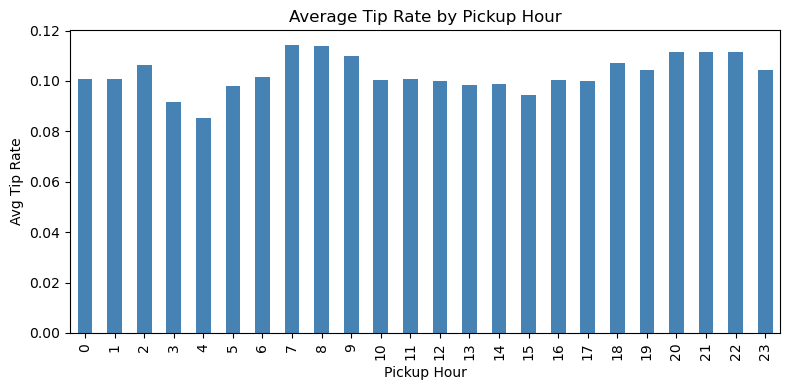

In [147]:
# Tipping behavior by time of day

print('Average Tip Rate: ', df['tip_rate'].mean().round(4))
print('')
avg_tip_by_hour = df.groupby('pickup_hour')['tip_rate'].mean()

plt.figure(figsize=(8,4))
avg_tip_by_hour.plot(kind='bar', color='steelblue')
plt.title("Average Tip Rate by Pickup Hour")
plt.xlabel("Pickup Hour")
plt.ylabel("Avg Tip Rate")
plt.tight_layout()
plt.show()


33.96


/var/folders/0y/4rkjz_214b7cqmfb9xs9h07c0000gn/T/ipykernel_45669/3049854236.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_tip_by_distance = df.groupby('distance_bin')['tip_rate'].mean()


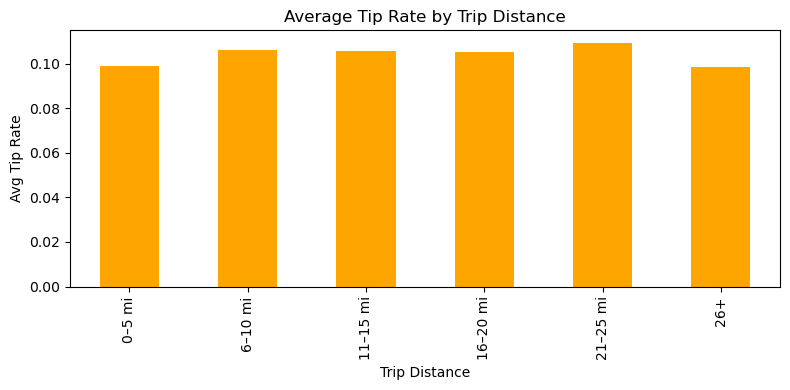

In [157]:
# Tipping behavior by trip distance

# Maximum value of trip distance
print(df['trip_distance'].max())

# Create bin
df['distance_bin'] = pd.cut(
    df['trip_distance'],
    bins=[0, 1, 2, 5, 10, 20, 30],
    labels=['0–5 mi', '6–10 mi', '11–15 mi', '16–20 mi', '21–25 mi', '26+'])

avg_tip_by_distance = df.groupby('distance_bin')['tip_rate'].mean()

plt.figure(figsize=(8,4))
avg_tip_by_distance.plot(kind='bar', color='orange')
plt.title("Average Tip Rate by Trip Distance")
plt.xlabel("Trip Distance")
plt.ylabel("Avg Tip Rate")
plt.tight_layout()
plt.show()


/var/folders/0y/4rkjz_214b7cqmfb9xs9h07c0000gn/T/ipykernel_45669/3332806322.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_df = df.pivot_table(


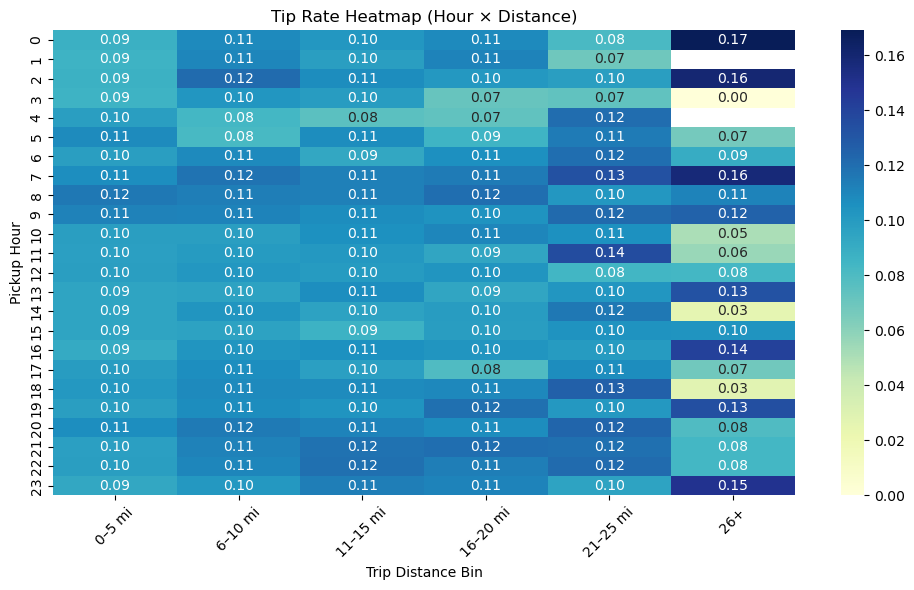

In [179]:
heatmap_df = df.pivot_table(
    values='tip_rate',
    index='pickup_hour',
    columns='distance_bin',
    aggfunc='mean'
)

plt.figure(figsize=(10,6))
sns.heatmap(heatmap_df, cmap='YlGnBu', annot=True, fmt=".2f")
plt.title("Tip Rate Heatmap (Hour × Distance)")
plt.xlabel("Trip Distance Bin")
plt.ylabel("Pickup Hour")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


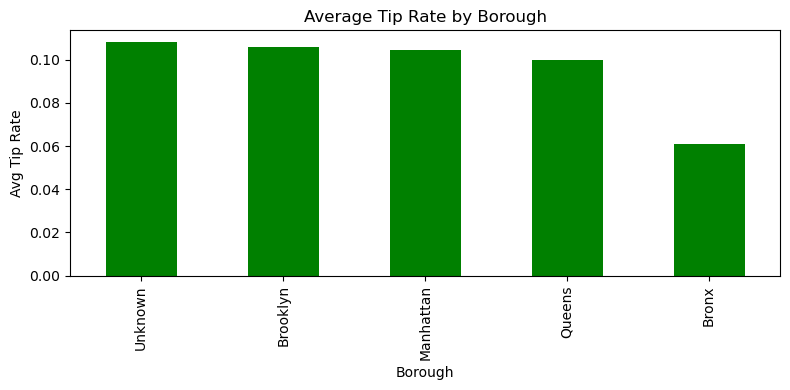

In [169]:
# Tipping behavior by borough

avg_tip_by_borough = df.groupby('Borough_x')['tip_rate'].mean().sort_values(ascending=False).head(5)

plt.figure(figsize=(8,4))
avg_tip_by_borough.plot(kind='bar', color='green')
plt.title("Average Tip Rate by Borough")
plt.xlabel("Borough")
plt.ylabel("Avg Tip Rate")
plt.tight_layout()
plt.show()


In [185]:
#5. How does passenger tipping behavior vary by time, distance, and borough?
print("Question 5 - Insights:")
print("1) Tipping behavior varies by time of day. Morning (6–10 AM) and evening (5–9 PM) show the highest tip rates, averaging 11–12%.")
print("2) Late-night trips (1–4 AM) also receive generous tips, likely influenced by nightlife or limited transportation options.")
print("3) Trip distance has only a small impact on tipping. Mid-range trips (6–15 miles) earn slightly higher tip rates, while very long trips (26+ miles) show lower tipping percentages.")
print("4) Combining time and distance reveals the strongest pattern: long-distance late-night trips generate the highest tip rates, often exceeding 15%.")
print("5) Tipping behavior differs across boroughs. Brooklyn and Manhattan riders tip the most (~10.5–11%), while the Bronx consistently shows the lowest average tip rate (~6%).")



Question 5 - Insights:
1) Tipping behavior varies by time of day. Morning (6–10 AM) and evening (5–9 PM) show the highest tip rates, averaging 11–12%.
2) Late-night trips (1–4 AM) also receive generous tips, likely influenced by nightlife or limited transportation options.
3) Trip distance has only a small impact on tipping. Mid-range trips (6–15 miles) earn slightly higher tip rates, while very long trips (26+ miles) show lower tipping percentages.
4) Combining time and distance reveals the strongest pattern: long-distance late-night trips generate the highest tip rates, often exceeding 15%.
5) Tipping behavior differs across boroughs. Brooklyn and Manhattan riders tip the most (~10.5–11%), while the Bronx consistently shows the lowest average tip rate (~6%).
